# MSCA 31013 Big Data Platform Final Project
### Group 6:  Ruoyun Zhang, Howard Lin, Yifan Gao
### Date:  December 6, 2021

## Data dictionary

•	marketplace: 2 letter country code of the marketplace where the review was written.

•	customer_id: Random identifier that can be used to aggregate reviews written by a single author.

•	review_id: The unique ID of the review.

•	productid: The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same productid.

•	product_parent: Random identifier that can be used to aggregate reviews for the same product.

•	product_title: Title of the product.

•	product_category: Broad product category that can be used to group reviews(also used to group the dataset into coherent parts).

•	star_rating: The 1-5 star rating of the review.

•	helpful_votes: Number of helpful votes.

•	total_votes: Number of total votes the review received.

•	vine: Review was written as part of the Vine program.

•	verified_purchase: The review is on a verified purchase.

•	review_headline: The title of the review.

•	review_body: The review text.

•	review_date: The date the review was written.


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import regexp_replace
from pyspark.sql import types
import pandas as pd
import numpy as np
from pandas import DataFrame

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000m") \
        .enableHiveSupport().appName('Amazon_BigData').getOrCreate()
        # configures the serializer used for not only shuffling 
        # data between worker nodes but also when serializing RDDs to disk.
        # faster and more compact than Java serialization (often as much as 10x)
        
        # Maximum allowable size of Kryo serialization buffer. 
        # This must be larger than any object you attempt to serialize. 
        # Increase this if you get a "buffer limit exceeded" exception inside Kryo.
        
sc = spark.sparkContext
## Bump up memory to avoid issue of no enough space to cache rdd in memory
# conf = sc._conf.setAll([('spark.executor.memory', '16g'),('spark.driver.memory','16g')])

## Import the dataset

#### From midway2

In [4]:
df = spark.read.csv("/scratch/midway2/ygao26/amazon/", sep=r'\t', inferSchema=True, header=True)

#### From Google Cloud

In [3]:
df = spark.read.csv("gs://bigdata-amazon-bucket1/google-cloud-dataproc-metainfo/580d6fef-16d6-4de4-b9d2-b4ddfdf4ff3f/data/", sep=r'\t', inferSchema=True, header=True) 

In [5]:
df = df.dropna()

In [6]:
df.limit(2).toPandas()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,2975964,R1NBG94582SJE2,B00I01JQJM,860486164,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,Camera,5,0,0,N,Y,Five Stars,ok,2015-08-31
1,US,23526356,R273DCA6Y0H9V7,B00TCO0ZAA,292641483,Professional 58mm Center Pinch Lens Cap for CA...,Camera,5,0,0,N,Y,Love it!!!,"Perfect, even sturdier than the original!",2015-08-31


In [7]:
print('Total Records in dataset',df.count())

Total Records in dataset 109830520


# 1. Exploratory Data Analysis

## 1.1 Data Cleaning and Modification

### 1.1.1 Convert columns to proper data type

In [6]:
from pyspark.sql.functions import col, to_date, year, month
from pyspark.sql.types import BooleanType

# Convert column to appropriate data types
df = df.withColumn("star_rating", col("star_rating").cast("int"))
df = df.withColumn("helpful_votes", col("helpful_votes").cast("int"))
df = df.withColumn("total_votes", col("total_votes").cast("int"))
df = df.withColumn("review_date", to_date("review_date"))

### 1.1.2 Add column year and month for the analysis

In [7]:
df = df.withColumn("year", year("review_date"))
df = df.withColumn("month", month("review_date"))
df = df.withColumn('year_month', col('review_date').substr(1, 7))

### 1.1.3 Check the distinct value of 'verified_purchase' and 'vine', change 'Y', 'N' to '1', '0'

In [12]:
df.select('verified_purchase').distinct().show() 

+-----------------+
|verified_purchase|
+-----------------+
|                Y|
|                N|
+-----------------+



In [13]:
df.select('vine').distinct().show()

+----+
|vine|
+----+
|   Y|
|   N|
+----+



In [8]:
df = df.withColumn('verified_purchase', regexp_replace('verified_purchase', 'Y', '1'))
df = df.withColumn('verified_purchase', regexp_replace('verified_purchase', 'N', '0'))
df = df.withColumn("verified_purchase", df.verified_purchase.cast(types.IntegerType()))

df = df.withColumn('vine', regexp_replace('vine', 'Y', '1'))
df = df.withColumn('vine', regexp_replace('vine', 'N', '0'))
df = df.withColumn("vine", df.vine.cast(types.IntegerType()))

### 1.1.4 Drop useless columns

#### There is only one market place, so we drop it.

In [28]:
df.select('marketplace').distinct().show()

+-----------+
|marketplace|
+-----------+
|         US|
+-----------+



In [9]:
#drop columns not needed for analysis
df = df.drop("marketplace")

#### Each row has an unique review_id, so we can drop it.

In [10]:
df = df.drop("review_id")

In [11]:
df.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- product_parent: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_category: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- helpful_votes: integer (nullable = true)
 |-- total_votes: integer (nullable = true)
 |-- vine: integer (nullable = true)
 |-- verified_purchase: integer (nullable = true)
 |-- review_headline: string (nullable = true)
 |-- review_body: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year_month: string (nullable = true)



In [11]:
df.limit(2).toPandas()

,customer_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,year,month,year_month
0,2975964,B00I01JQJM,860486164,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,Camera,5,0,0,0,1,Five Stars,ok,2015-08-31,2015,8,2015-08
1,23526356,B00TCO0ZAA,292641483,Professional 58mm Center Pinch Lens Cap for CA...,Camera,5,0,0,0,1,Love it!!!,"Perfect, even sturdier than the original!",2015-08-31,2015,8,2015-08


## 1.2 Data exploration and visualization

### 1.2.1 Calculate the total count of each product category

#### How many products are there?

In [11]:
df.select('product_id').distinct().count()

15218114

#### What is the most popular category?

In [12]:
df.groupby('product_category').count().sort("count").orderBy(["count"], ascending=[0]).show()

+--------------------+-------+
|    product_category|  count|
+--------------------+-------+
|            Wireless|9023812|
|                  PC|6965186|
|         Mobile_Apps|6507784|
|Digital_Ebook_Pur...|6350236|
|           Video DVD|6165161|
|             Apparel|5905389|
|               Music|5529463|
|Health & Personal...|5331772|
|              Beauty|5114785|
|Digital_Video_Dow...|5114466|
|                Toys|4921264|
|              Sports|4853135|
|               Shoes|4373707|
|               Books|3944056|
|          Automotive|3514268|
|         Electronics|3105119|
|     Office Products|2644508|
|        Pet Products|2643246|
|             Grocery|2402229|
|            Outdoors|2305367|
+--------------------+-------+
only showing top 20 rows



#### What is the least popular category?

In [13]:
df.groupby('product_category').count().filter(("count>25")).sort("count").orderBy(["count"], ascending=[1]).dropna().show()

+--------------------+-------+
|    product_category|  count|
+--------------------+-------+
|             Luggage|     78|
|     Lawn and Garden|   1212|
|             Kitchen|   1843|
|                Home|   2007|
|    Home Improvement|   3731|
|  Home Entertainment|  36522|
|Personal_Care_App...|  85987|
|    Major Appliances|  96888|
|    Digital_Software| 102077|
|  Mobile_Electronics| 105156|
| Digital_Video_Games| 145425|
|           Gift Card| 149080|
|            Software| 341966|
|               Video| 427287|
|           Furniture| 791979|
| Musical Instruments| 915626|
|             Watches| 971264|
|               Tools|1748483|
|                Baby|1758626|
|Digital_Music_Pur...|1796461|
+--------------------+-------+
only showing top 20 rows



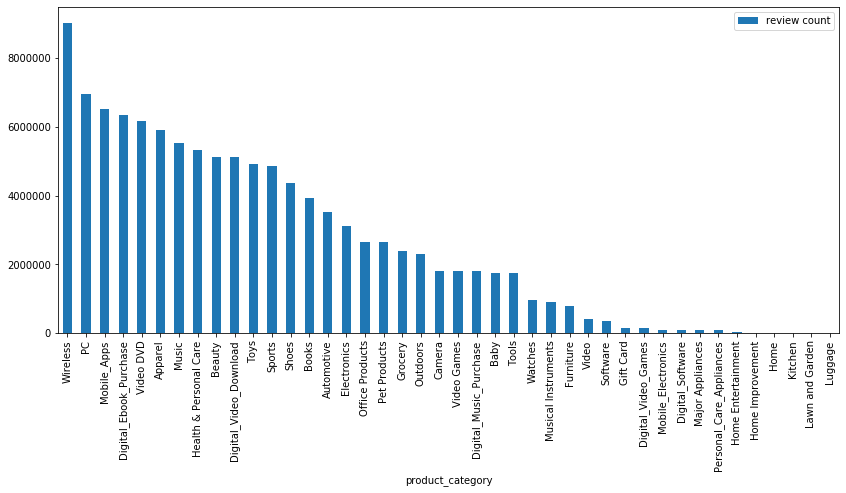

In [14]:
#Count product_category by product_category type 
df_category = df.groupby("product_category").count().orderBy("count", ascending=False)
df_category_highest = df_category.toPandas()
df_category_highest.rename(columns = {'count':'review count'}, inplace = True)
df_category_highest.plot.bar(x='product_category',figsize=(14, 6))

### 1.2.2 Calculate the average star_rating of each product category¶

In [15]:
average_rating=df.groupby('product_category').avg('star_rating')

In [16]:
from pyspark.sql.window import Window
windowSpec=Window.orderBy(F.desc('avg(star_rating)'))

In [17]:
average_rating=average_rating.withColumn("rating_rank",F.row_number().over(windowSpec))

#### Category with highest star rating.

In [18]:
average_rating.sort("rating_rank").orderBy(["rating_rank"], ascending=[1]).show()

+--------------------+------------------+-----------+
|    product_category|  avg(star_rating)|rating_rank|
+--------------------+------------------+-----------+
|           Gift Card| 4.731352294070298|          1|
|Digital_Music_Pur...| 4.638542111406816|          2|
|               Music| 4.435098851371281|          3|
|           Video DVD| 4.312607732385254|          4|
|             Grocery| 4.312269146696672|          5|
|Digital_Ebook_Pur...| 4.262511660983939|          6|
|               Tools| 4.262147816135473|          7|
| Musical Instruments| 4.251171329778752|          8|
|          Automotive| 4.246277176356498|          9|
|               Shoes| 4.241344241852507|         10|
|            Outdoors| 4.239968733828497|         11|
|              Sports|  4.22921513619547|         12|
|                Toys|4.2145692651318845|         13|
|Digital_Video_Dow...| 4.209598225894942|         14|
|               Books|  4.20874830377662|         15|
|               Video| 4.196

#### Category with the lowest star rating

In [19]:
average_rating.sort("rating_rank").orderBy(["rating_rank"], ascending=[0]).show()

+--------------------+------------------+-----------+
|    product_category|  avg(star_rating)|rating_rank|
+--------------------+------------------+-----------+
|    Digital_Software|3.5393869333934185|         42|
|            Software|3.5671616476491814|         41|
|    Major Appliances| 3.716363223515812|         40|
|  Mobile_Electronics|3.7639697211761574|         39|
| Digital_Video_Games|3.8531407942238265|         38|
|            Wireless|3.8921643092741736|         37|
|Personal_Care_App...|3.9774617093281543|         36|
|             Kitchen|3.9934888768312535|         35|
|         Mobile_Apps| 4.033717314526727|         34|
|         Electronics| 4.035709742525166|         33|
|  Home Entertainment| 4.036964021685559|         32|
|                Home| 4.052316890881913|         31|
|         Video Games| 4.060909568831088|         30|
|             Luggage| 4.064102564102564|         29|
|     Office Products|  4.07249061072986|         28|
|           Furniture| 4.083

### 1.2.3 Verified purchase ratio by each product category

In [20]:
verified_ratio = df.crosstab('product_category', 'verified_purchase')

In [21]:
verified_ratio=verified_ratio.withColumn('verified_ratio', F.round((F.col('1')/(F.col('1')+F.col('0'))),3))

In [22]:
verified_ratio=verified_ratio.join(average_rating, verified_ratio['product_category_verified_purchase'] == average_rating['product_category'], 'outer')

#### What is the highest verified ratio by category

In [23]:
verified_ratio.sort("verified_ratio").orderBy(["verified_ratio"], ascending=[0]).drop('0','1','product_category').show()

+----------------------------------+--------------+------------------+-----------+
|product_category_verified_purchase|verified_ratio|  avg(star_rating)|rating_rank|
+----------------------------------+--------------+------------------+-----------+
|                       Mobile_Apps|         0.954| 4.033717314526727|         34|
|                  Home Improvement|         0.927| 4.131064057893326|         22|
|                Home Entertainment|         0.923| 4.036964021685559|         32|
|                        Automotive|         0.918| 4.246277176356498|          9|
|                         Gift Card|         0.913| 4.731352294070298|          1|
|                         Furniture|         0.907| 4.083964347539518|         27|
|                             Shoes|         0.903| 4.241344241852507|         10|
|                           Apparel|           0.9| 4.105200690420225|         25|
|                   Lawn and Garden|         0.887| 4.128712871287129|         24|
|   

Categories with highest verification rate are Mobile_Apps, Home_Improvement, Home_Entertainment, Automotive, Gift_Card. However, we can't tell if there is any strong relationship between the star rating and the verification rate from here.

#### What is the lowest verified ratio by category

In [24]:
verified_ratio.sort("verified_ratio").orderBy(["verified_ratio"], ascending=[1]).drop('0','1','product_category').show()

+----------------------------------+--------------+------------------+-----------+
|product_category_verified_purchase|verified_ratio|  avg(star_rating)|rating_rank|
+----------------------------------+--------------+------------------+-----------+
|                             Books|         0.179|  4.20874830377662|         15|
|                             Video|         0.238| 4.196926187784791|         16|
|                             Music|         0.419| 4.435098851371281|          3|
|                          Software|         0.572|3.5671616476491814|         41|
|                         Video DVD|          0.65| 4.312607732385254|          4|
|                       Video Games|         0.656| 4.060909568831088|         30|
|              Digital_Video_Dow...|          0.67| 4.209598225894942|         14|
|                  Digital_Software|         0.694|3.5393869333934185|         42|
|                  Major Appliances|          0.71| 3.716363223515812|         40|
|   

Categories with lowest verification rate are Books, Video, Music, Software, Video_DVD. However, we can't tell if there is a strong relationship between the star rating and the verification rate from here.

### 1.2.4 Calculate the correlation between star_rating, helpful_votes, total_votes and verified_purchase

In [25]:
choose_col = ['star_rating', 'helpful_votes', 'total_votes', 'verified_purchase']

In [26]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=choose_col, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col,'pearson')

In [27]:
cor_matrix = matrix.collect()[0][0]
corrmatrix = cor_matrix.toArray().tolist()

In [28]:
corrmatrix_df = spark.createDataFrame(corrmatrix,choose_col)
corrmatrix_df = corrmatrix_df.toPandas()

In [29]:
corrmatrix_df.index = choose_col

In [30]:
corrmatrix_df

,star_rating,helpful_votes,total_votes,verified_purchase
star_rating,1.000000,-0.020300,-0.045593,0.043456
helpful_votes,-0.020300,1.000000,0.987052,-0.055141
total_votes,-0.045593,0.987052,1.000000,-0.070857
verified_purchase,0.043456,-0.055141,-0.070857,1.000000


Looks like total_votes and helpful_votes have strong positive relationship. The other relationships are not significant.

### 1.2.5 Calculate the total count of each customer

#### How many customers are there?

In [31]:
df.select('customer_id').distinct().count()

27533085

#### Customers that provide the most reviews

In [13]:
customer=df.groupby('customer_id').count().sort("count").orderBy(["count"], ascending=[0])

In [14]:
from pyspark.sql.window import Window
windowSpec=Window.orderBy(F.desc('count'))

In [15]:
customer=customer.withColumn("review_number_rank",F.row_number().over(windowSpec))

In [14]:
customer.sort("review_number_rank").orderBy(["review_number_rank"], ascending=[1]).show()

+-----------+-----+------------------+
|customer_id|count|review_number_rank|
+-----------+-----+------------------+
|   50122160|23587|                 1|
|   50732546|10194|                 2|
|   50736950| 9985|                 3|
|   18116317| 8689|                 4|
|   52496677| 8144|                 5|
|   43430756| 6930|                 6|
|   14539589| 6497|                 7|
|   50913245| 6279|                 8|
|   20018062| 6182|                 9|
|   50881246| 6157|                10|
|   51184997| 5741|                11|
|    7080939| 5619|                12|
|   38214553| 5531|                13|
|   42418272| 4805|                14|
|   30678701| 4782|                15|
|   23267387| 4690|                16|
|   22073263| 4625|                17|
|   53037408| 4589|                18|
|   50068216| 4471|                19|
|   51110953| 4370|                20|
+-----------+-----+------------------+
only showing top 20 rows



### 1.2.6 Calculate the average star_rating of each customer

In [16]:
star_rating_customer = df.groupby('customer_id').avg('star_rating')
customer = customer.withColumnRenamed("customer_id", "customer")
star_rating_customer = star_rating_customer.join(customer, star_rating_customer['customer_id'] == customer['customer'], 'outer')

In [17]:
star_rating_customer=star_rating_customer.drop('customer')

In [22]:
star_rating_customer = star_rating_customer.withColumnRenamed("avg(star_rating)","avg_star_rating")
star_rating_customer.filter(("avg_star_rating>4.7")).sort("count").orderBy(["count"], ascending=[0]).show()

+-----------+------------------+-----+------------------+
|customer_id|   avg_star_rating|count|review_number_rank|
+-----------+------------------+-----+------------------+
|   50122160|  4.99813456565057|23587|                 1|
|   14539589|   4.8867169462829| 6497|                 7|
|   20018062| 4.809608540925267| 6182|                 9|
|    7080939| 4.999822032390105| 5619|                12|
|   22073263|4.7548108108108105| 4625|                17|
|   53037408| 4.911963390716932| 4589|                18|
|   50199793| 4.774026614095614| 4058|                22|
|   50345651| 4.979022704837117| 4052|                23|
|   15725862|4.7483594864479315| 3505|                29|
|   44731853| 4.731501057082452| 3311|                34|
|   49837360|  4.72685609532539| 3273|                35|
|   15536614| 4.998916576381365| 2769|                46|
|   53017806| 4.883236994219653| 2595|                51|
|   51591392| 4.994428969359332| 2513|                57|
|   12201275| 

From this table we can find those who provide the most review and the average rating they give. Those who provide higher-than-normal number of review with high average rating can be suspicious.

For those who are suspicious, we can check if their purchases are verified and their return rate.

In [24]:
star_rating_customer.filter(('avg_star_rating<1.3')).sort("count").orderBy(["count"], ascending=[0]).show()

+-----------+------------------+-----+------------------+
|customer_id|   avg_star_rating|count|review_number_rank|
+-----------+------------------+-----+------------------+
|   48608140|               1.0|  205|              8142|
|   16071656|1.2471264367816093|  174|             11839|
|   44270361| 1.049079754601227|  163|             13808|
|   18853502|1.2352941176470589|  153|             15817|
|   37141039|               1.0|  150|             16672|
|   47619896|1.2465753424657535|  146|             17472|
|   30793307| 1.036764705882353|  136|             20762|
|   41542504|               1.0|  132|             22034|
|   42329785|1.0743801652892562|  121|             26745|
|   40151153|1.1090909090909091|  110|             32949|
|   24957250|1.2545454545454546|  110|             32650|
|   20372208|1.2660550458715596|  109|             33583|
|   39496978|1.2376237623762376|  101|             39274|
|   13081743|1.0612244897959184|   98|             41512|
|   17703766| 

From this table we can find those who provide the most review and the average rating they give. Those who provide higher-than-normal number of review with low average rating can be suspicious.

For those who are suspicious, we can check if their purchases are verified and their return rate.

### 1.2.7 Plot a monthly time series line chart for the number of review

In [19]:
monthly=df.filter(('year>2010')).groupby('year_month').count().sort("year_month").orderBy(["year_month"], ascending=[1])

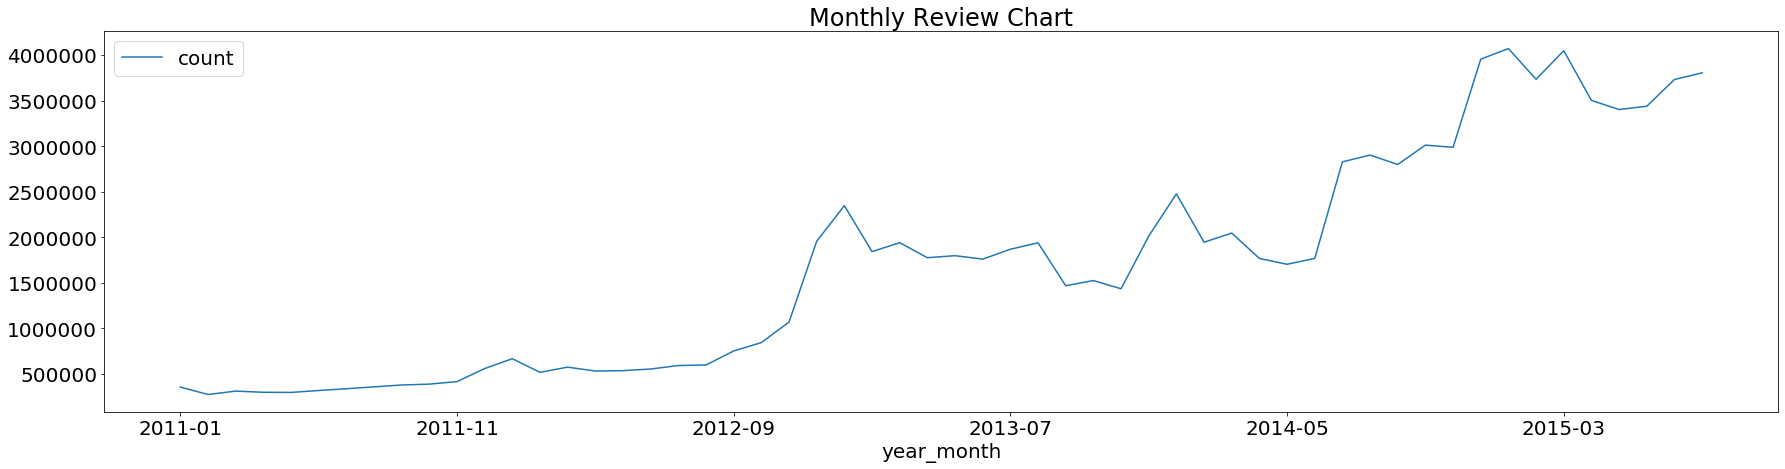

In [20]:
import matplotlib.pyplot as plt

monthly=monthly.dropna()
pdf = monthly.toPandas()

pdf.plot(figsize=(30,7), kind='line', x="year_month", fontsize=20, title='Monthly Review Chart')

### 1.2.8 Plot a monthly time series line chart for the average star rating

In [22]:
monthly_average_rating=df.filter(('year>2010')).groupby('year_month').avg('star_rating').sort("year_month").orderBy(["year_month"], ascending=[1])

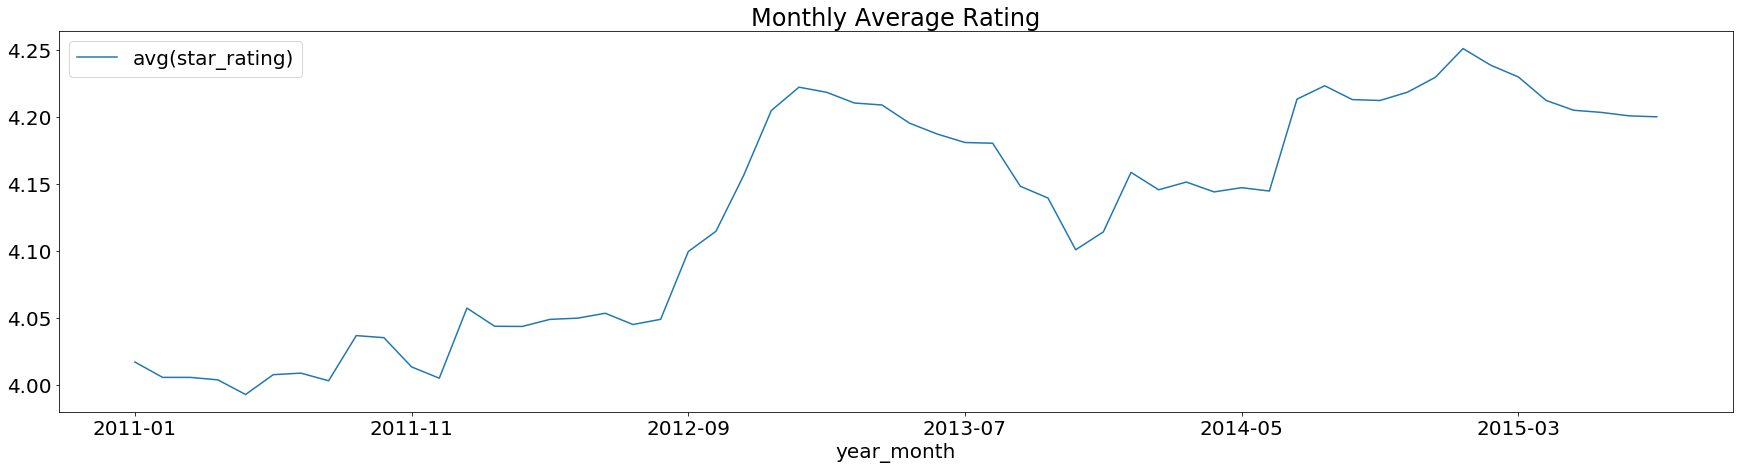

In [23]:
import matplotlib.pyplot as plt

monthly_average_rating = monthly_average_rating.dropna()
pdf = monthly_average_rating.toPandas()

pdf.plot(figsize=(30,7), kind='line', x="year_month", fontsize=20, title='Monthly Average Rating')

#### By top 10 product category

In [33]:
# Top 10 product category by count
top10_product = df.groupby('product_category').count().sort("count").orderBy(["count"], ascending=[0])
top10_product = top10_product.select("product_category").toPandas().head(10)
monthly_average_rating = df.filter(('year>2010')).filter(df.product_category.isin(list(top10_product['product_category']))).groupby('year_month').pivot("product_category").avg('star_rating').sort("year_month").orderBy(["year_month"], ascending=[1])

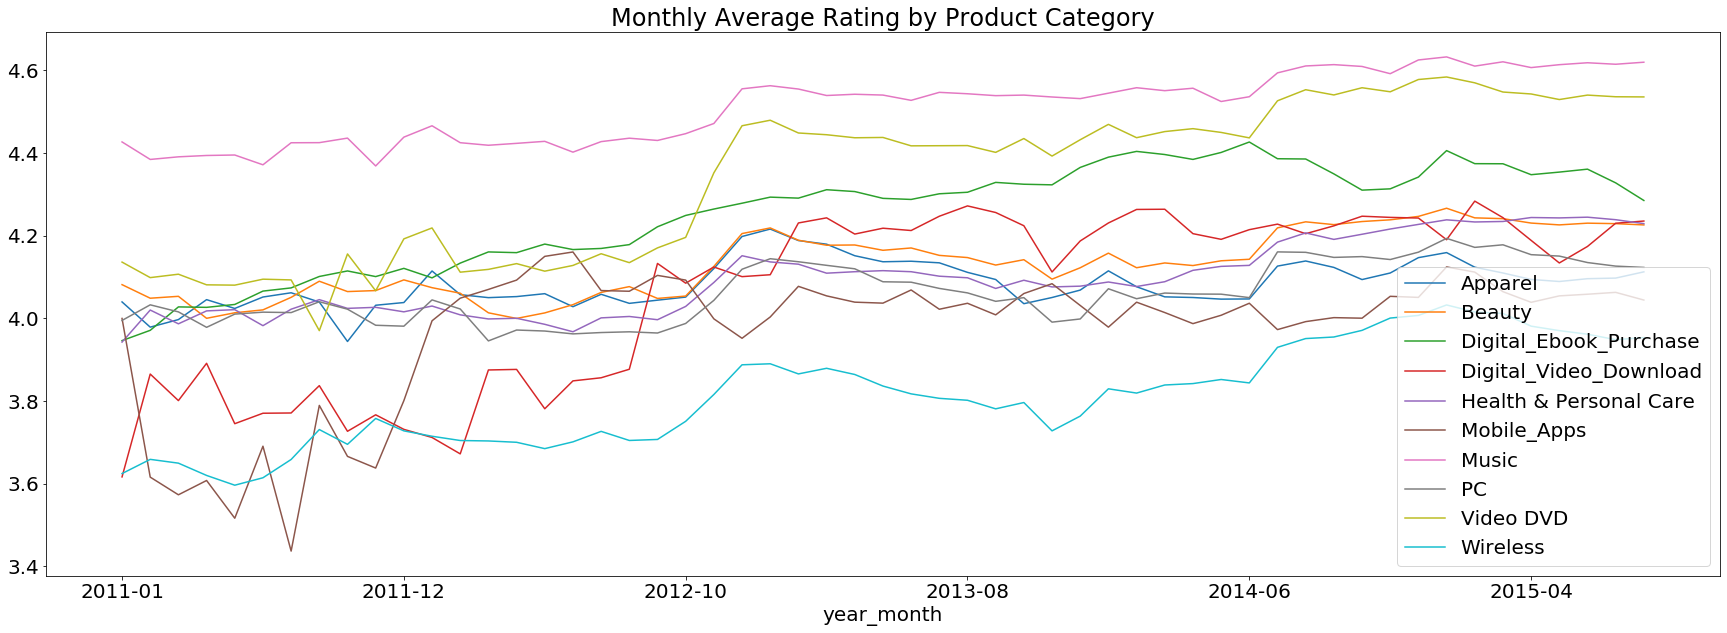

In [34]:
import matplotlib.pyplot as plt

monthly_average_rating = monthly_average_rating.dropna()
pdf = monthly_average_rating.toPandas()

pdf.plot(figsize=(30,10), kind='line', x="year_month", fontsize=20, title='Monthly Average Rating by Product Category')

### 1.2.9 Plot a monthly time series line chart for the verified ratio

#### Firstly plot the number of unverified and verified review in each month

In [35]:
verified_ratio_month = df.filter(('year>2010')).crosstab('year_month', 'verified_purchase').sort("year_month_verified_purchase").orderBy(["year_month_verified_purchase"], ascending=[1])

In [36]:
verified_ratio_month=verified_ratio_month.withColumnRenamed("year_month_verified_purchase", "year_month")

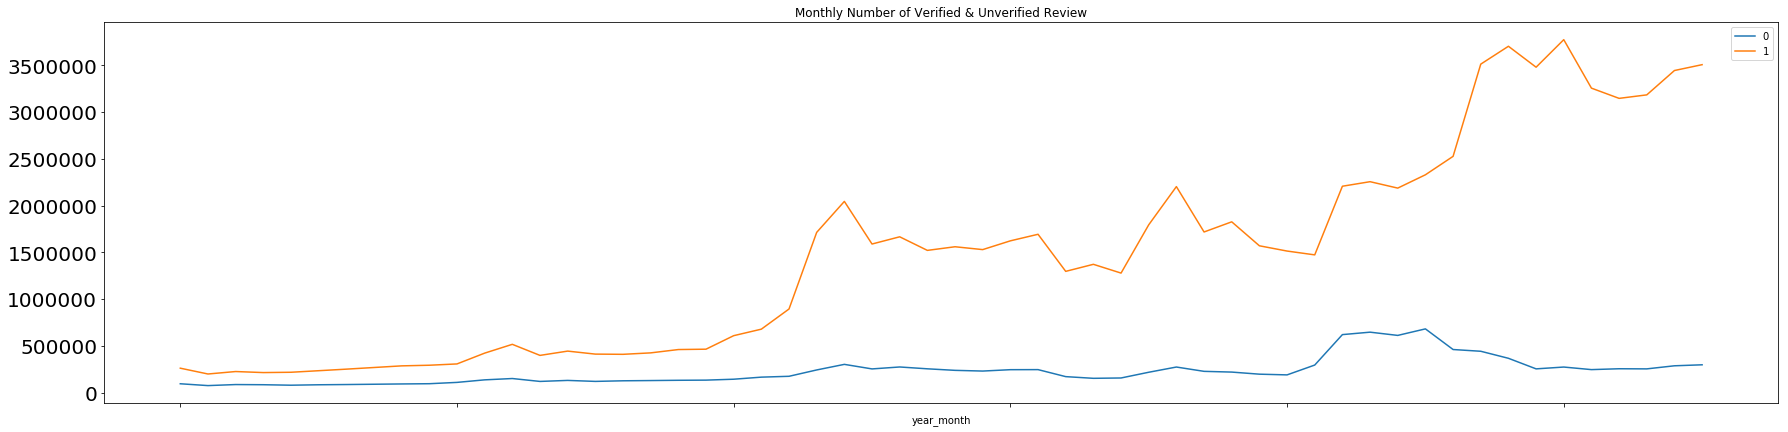

In [37]:
import matplotlib.pyplot as plt

verified_ratio_month = verified_ratio_month.dropna()
pdf = verified_ratio_month.toPandas()

pdf.plot(figsize=(30,7), kind='line', x="year_month",fontsize=20, title='Monthly Number of Verified & Unverified Review')

#### Plot verified ratio by month

In [35]:
monthly_verified_ratio = df.filter(('year>2010')).crosstab('year_month', 'verified_purchase')

In [36]:
monthly_verified_ratio=monthly_verified_ratio.withColumn('verified_ratio', F.round((F.col('1')/(F.col('1')+F.col('0'))),3)).drop('0','1').sort("year_month_verified_purchase").orderBy(["year_month_verified_purchase"], ascending=[1])

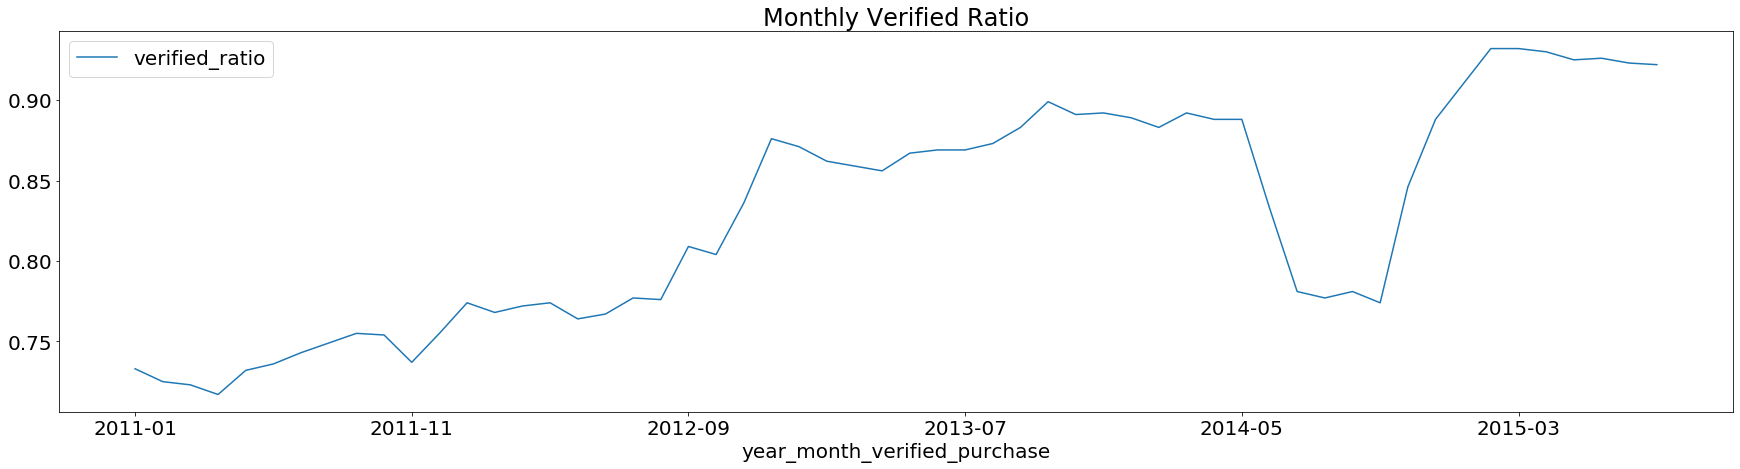

In [37]:
import matplotlib.pyplot as plt

monthly_verified_ratio = monthly_verified_ratio.dropna()
pdf = monthly_verified_ratio.toPandas()
pdf.plot(figsize=(30,7), kind='line', x="year_month_verified_purchase", fontsize=20, title='Monthly Verified Ratio')

### 1.2.10 Calculate the correlation among monthly number of review, average rating and verified ratio

In [35]:
monthly_average_rating=monthly_average_rating.withColumnRenamed("year_month", "year_month1")
monthlynumber = monthly.join(monthly_average_rating, monthly['year_month'] == monthly_average_rating['year_month1'], 'outer').drop('year_month1')
monthlynumber = monthlynumber.join(monthly_verified_ratio, monthlynumber['year_month'] == monthly_verified_ratio['year_month_verified_purchase'], 'outer').drop('year_month_verified_purchase').sort("year_month").orderBy(["year_month"], ascending=[1])

In [36]:
monthlynumber.printSchema()

root
 |-- year_month: string (nullable = true)
 |-- count: long (nullable = true)
 |-- avg(star_rating): double (nullable = true)
 |-- verified_ratio: double (nullable = true)



In [37]:
choose_col = ['count', 'avg(star_rating)', 'verified_ratio']

In [39]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=choose_col, outputCol=vector_col)
monthlynumber_vector = assembler.transform(monthlynumber).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(monthlynumber_vector, vector_col,'pearson')

In [40]:
cor_matrix = matrix.collect()[0][0]
corrmatrix = cor_matrix.toArray().tolist()

In [41]:
corrmatrix_df = spark.createDataFrame(corrmatrix,choose_col)
corrmatrix_df = corrmatrix_df.toPandas()

In [42]:
corrmatrix_df.index = choose_col

In [43]:
corrmatrix_df

,count,avg(star_rating),verified_ratio
count,1.000000,0.898380,0.785264
avg(star_rating),0.898380,1.000000,0.796682
verified_ratio,0.785264,0.796682,1.000000


We found that there are close positive relationship among the number of reviews, average ratings and verified ratio.

### 1.2.11 verified purchase v.s. unverified purchase

In [22]:
df.groupby('verified_purchase').count().sort("count").orderBy(["verified_purchase"], ascending=[0]).show()

+-----------------+--------+
|verified_purchase|   count|
+-----------------+--------+
|                1|86637485|
|                0|23179351|
+-----------------+--------+



#### number of star rating by purchase type

In [23]:
df.groupby('verified_purchase','star_rating').count().sort("count").orderBy(["verified_purchase",'star_rating'], ascending=[0]).show()

+-----------------+-----------+--------+
|verified_purchase|star_rating|   count|
+-----------------+-----------+--------+
|                1|          5|53673818|
|                1|          3| 7014519|
|                1|          1| 6959407|
|                1|          4|14783881|
|                1|          2| 4205860|
|                0|          2| 1285586|
|                0|          5|13374982|
|                0|          3| 1887046|
|                0|          1| 2475438|
|                0|          4| 4156299|
+-----------------+-----------+--------+



### 1.2.12 Number of Ratings by Stars

imbalance dataset

In [20]:
pdf1 = df.groupby('star_rating').count().sort("count").orderBy(["star_rating"], ascending=[0]).toPandas()
pdf1.head()

,star_rating,count
0,5,67048800
1,4,18940180
2,3,8901565
3,2,5491446
4,1,9434845


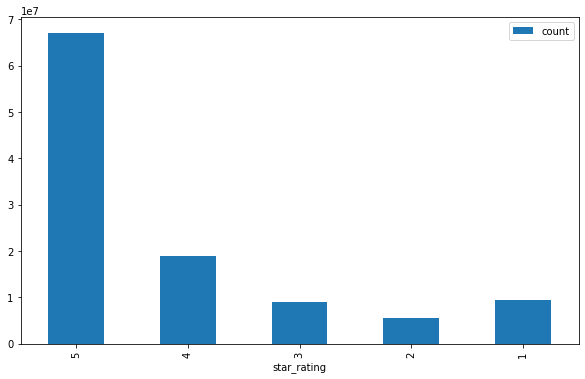

In [21]:
pdf1.plot.bar(x='star_rating',figsize=(10, 6))

# 2. Predict Star Rating with NLP

## 2.1 First we map star rating to three groups: 1, 3, 5

In the subsequent modeling, we will predict star rating with sentiment analysis model. To that end, we will convert our target variable to a less granular level of 3 so that each sentiment (positive, neutral and negative) can be mapped to each star rating. If star rating is 4 or 5, convert to 5. If star rating is 3, convert to 3. If star rating is 1 or 2, convert to 1.

In [48]:
def star_transf(x):
    '''
    Function to map star rating to less granular level
    If star rating is 4 or 5, map to 5. If star rating
    is 3, map to 3. If star rating is 1 or 2, map to 1.
    This way, we can dovetail the classitification
    problem with sentiment analysis.
    
    '''
    return 5 if x >= 4 else 3 if x == 3 else 1

In [49]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.functions import col

df2 = df.select(['star_rating', 'review_body','product_category','review_date'])
df2 = df2.dropna()

# Map star rating to less granular level 
func1 = UserDefinedFunction(star_transf, StringType())
df2 = df2.withColumn('star_rating', func1(df.star_rating))
df2 = df2.withColumn("star_rating", col("star_rating").cast("int"))

df2.groupBy("star_rating").count().orderBy("star_rating").show()

+-----------+--------+
|star_rating|   count|
+-----------+--------+
|          1|14926291|
|          3| 8901565|
|          5|85988980|
+-----------+--------+



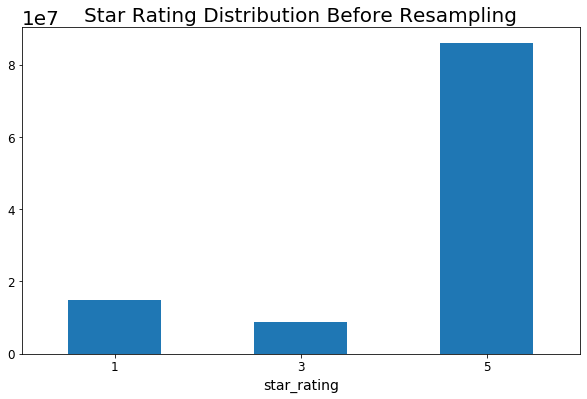

In [82]:
pdf2 = df2.groupBy("star_rating").count().orderBy("star_rating").toPandas()
fig = pdf2.plot.bar(x='star_rating', figsize=(10, 6), fontsize=12, title='Star Rating Distribution Before Resampling', rot = 0)
fig.axes.title.set_size(20)
fig.xaxis.label.set_size(14)
fig.get_legend().remove()

Note the distribution of star rating is unbalanced. For the subsequent modeling, we want each class to be equally presented. Therefore, we will resample to ensure the dataset is balanced.

In [51]:
# Stratify sample the data per class given the unbalanced class
frac_1 = df2.filter(df2.star_rating == 3).count()/df2.filter(df2.star_rating == 1).count()
frac_3 = 1
frac_5 = df2.filter(df2.star_rating == 3).count()/df2.filter(df2.star_rating == 5).count()
df2 = df2.sampleBy("star_rating", fractions={1: frac_1, 3: frac_3, 5: frac_5}, seed=0)
df2.groupBy("star_rating").count().orderBy("star_rating").show()

+-----------+-------+
|star_rating|  count|
+-----------+-------+
|          1|8900441|
|          3|8901565|
|          5|8897552|
+-----------+-------+



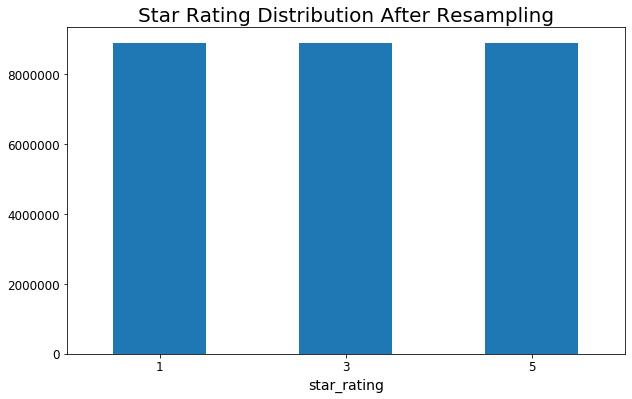

In [81]:
pdf3 = df2.groupBy("star_rating").count().orderBy("star_rating").toPandas()
fig = pdf3.plot.bar(x='star_rating', figsize=(10, 6), fontsize=12, title='Star Rating Distribution After Resampling', rot = 0)
fig.axes.title.set_size(20)
fig.xaxis.label.set_size(14)
fig.get_legend().remove()

Each class is now balanced.

In [ ]:
import warnings
warnings.filterwarnings("ignore")
df2.show()
df2.printSchema()

+-----------+--------------------+----------------+-----------+
|star_rating|         review_body|product_category|review_date|
+-----------+--------------------+----------------+-----------+
|          1|Bought cables in ...|              PC| 2015-08-31|
|          3|This demn tablet ...|              PC| 2015-08-31|
|          1|After exactly 45 ...|              PC| 2015-08-31|
|          1|IT HAS ALREADY CR...|              PC| 2015-08-31|
|          1|Very disappointed...|              PC| 2015-08-31|
|          1|I have owned this...|              PC| 2015-08-31|
|          1|I cannot get it t...|              PC| 2015-08-31|
|          1|Totally wasted $6...|              PC| 2015-08-31|
|          5|        product good|              PC| 2015-08-31|
|          1|    tinny weak sound|              PC| 2015-08-31|
|          5|Great protector c...|              PC| 2015-08-31|
|          5|Nice little enclo...|              PC| 2015-08-31|
|          5|Very reliable, be...|      

In [ ]:
df3 = df2.select(['star_rating', 'review_body'])

## 2.2 Base model

In [11]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

#tokenize words
tokenizer = Tokenizer(inputCol="review_body", outputCol="words")
#Stop word
remover = StopWordsRemover(inputCol="words", outputCol="filtered")
#hashingTF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=100)
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [ ]:
pipeline1 = Pipeline(stages=[tokenizer,remover,hashingTF,idf])
encodedData1 = pipeline1.fit(df3).transform(df3)
#encodedData1 = encodedData1.sample(withReplacement=False, fraction=0.3)
train1, test1 = encodedData1.randomSplit([0.8,0.2])

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# Set parameters for Logistic Regression
lr = LogisticRegression(maxIter=10, featuresCol = 'features', labelCol='star_rating')
# rf = RandomForestClassifier(labelCol="star_rating", featuresCol="features")

model1 = lr.fit(train1)
predictions1 = model1.transform(test1)

In [ ]:
predictions1.show(3)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|star_rating|         review_body|               words|            filtered|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|          1|&#34;Hey I got an...|[&#34;hey, i, got...|[&#34;hey, got, i...|(100,[1,3,4,7,8,1...|(100,[1,3,4,7,8,1...|[-7.2874199956858...|[1.55901751002938...|       1.0|
|          1|(UPDATE) after 2 ...|[(update), after,...|[(update), 2, mon...|(100,[5,7,10,16,2...|(100,[5,7,10,16,2...|[-7.2874080288406...|[1.45888771857800...|       3.0|
|          1|-An amazing lapto...|[-an, amazing, la...|[-an, amazing, la...|(100,[3,4,6,7,10,...|(100,[3,4,6,7,10,...|[-7.2874239086942...|[

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator1 = MulticlassClassificationEvaluator(labelCol="star_rating", predictionCol="prediction")

print(evaluator1.evaluate(predictions1, {evaluator1.metricName: "accuracy"}))
print(evaluator1.evaluate(predictions1, {evaluator1.metricName: "f1"}))

0.4687347561832512
0.46133964338731104


In [ ]:
# Check point data
predictions1.select('star_rating','prediction').coalesce(1).write.csv('gs://bigdata-amazon-bucket1/google-cloud-dataproc-metainfo/580d6fef-16d6-4de4-b9d2-b4ddfdf4ff3f/checkpoint/predictions1', header = 'true')

## 2.3 SparkNLP model

In [14]:
from pyspark.ml.feature import HashingTF
from sparknlp.annotator import Lemmatizer, Stemmer, Tokenizer, Normalizer
from sparknlp.base import DocumentAssembler, Finisher
from pyspark.ml import Pipeline

# The Document Assembler takes the raw text data and convert it into a format that can
# be tokenized.
document_assembler = DocumentAssembler().setInputCol("review_body").setOutputCol("document")
# The Tokenizer takes data that is of the "Document" type and tokenizes it.
tokenizer = Tokenizer().setInputCols(["document"]).setOutputCol("token")
# The Normalizer will group words together based on similar semantic meaning.
normalizer = Normalizer().setInputCols(["token"]).setOutputCol("normalizer")
# The Stemmer takes objects of class "Token" and converts the words into their
# root meaning.
stemmer = Stemmer().setInputCols(["normalizer"]).setOutputCol("stem")
# The Finisher signals to spark-nlp allows us to access the data outside of spark-nlp
# components.
finisher = Finisher().setInputCols(["stem"]).setOutputCols(["to_spark"]).setValueSplitSymbol(" ")

# Implement HashingTF
htf = HashingTF(inputCol="to_spark", outputCol="features", numFeatures=100)

In [15]:
# Create a Pipeline object
pipeline2 = Pipeline(
    stages = [
        document_assembler,
        tokenizer,
        normalizer,
        stemmer,
        finisher,
        htf
    ]
)
encodedData2 = pipeline2.fit(df3).transform(df3)
# encodedData2 = encodedData2.sample(withReplacement=False, fraction=0.3)
train2, test2 = encodedData2.randomSplit([0.8,0.2])

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

# Set parameters for Logistic Regression
lr = LogisticRegression(maxIter=10, featuresCol = 'features', labelCol='star_rating')
# rf = RandomForestClassifier(labelCol="star_rating", featuresCol="features")

model2 = lr.fit(train2)
predictions2 = model2.transform(test2)

In [17]:
predictions2.show(3)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|star_rating|         review_body|            to_spark|            features|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|          1|(I happen to be t...|[i, happen, to, b...|(100,[0,1,3,4,5,6...|[-7.2873108217242...|[1.39499403929393...|       1.0|
|          1|*** UPDATE 4/29/2...|[updat, br, i, re...|(100,[0,1,2,3,4,5...|[-7.2874897136696...|[1.47232433611979...|       3.0|
|          1|***Buyer beware, ...|[buyer, bewar, th...|(100,[1,5,7,8,13,...|[-7.2872450337256...|[1.33739739030157...|       1.0|
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



In [ ]:
# Check point data
predictions2.select('star_rating','prediction').coalesce(1).write.csv('/scratch/midway2/ygao26/data/predictions2', header = 'true')

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator2 = MulticlassClassificationEvaluator(labelCol="star_rating", predictionCol="prediction")

print(evaluator2.evaluate(predictions2, {evaluator2.metricName: "accuracy"}))
print(evaluator2.evaluate(predictions2, {evaluator2.metricName: "f1"}))

0.5187991553577624


0.5140307208853219


## 2.4 SparkNLP sentiment model

We will be using Sparknlp pretrained sentiment model to predict the star rating. Theoretically this is a bit odd way of using sentiment model as it's an unsupervised learning so we don't really need the target variable star_rating. We will solely rely on review_body variable and pretrained sentiment model to analyze the sentiment of each user, which is categorized as negative, neutral and positive. \ Then, we will do a trick to convert the sentiment to the three class star_rating: negative to 1, neutral to 3 and positive to 5. This way we can calculate the metrics and compare with the previous models. \ Note our assumption in this model is the sentiment is an analogy to star rating. Intuitively, this makes sense. The more positive one's review is, the higher star rating one will give.

In [17]:
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import *
from sparknlp.annotator import *

# The Document Assembler takes the raw text data and convert it into a format that can
# be tokenized.
documentAssembler = DocumentAssembler().setInputCol("review_body").setOutputCol("document")

# The Universal Sentence Encoder encodes text into high-dimensional vectors 
# that can be used for text classification, semantic similarity, clustering 
# and other natural language tasks. It's a pretrained model.
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# The default sentiment model is "sentimentdl_use_imdb". 
# It is english sentiment analysis trained on the IMDB dataset. 
sentimentdl = SentimentDLModel.pretrained()\
.setThreshold(0.6) \
.setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_imdb download started this may take some time.
Approximate size to download 12 MB
[OK!]


In [ ]:
def SentIndexer(x):
    '''
    Function to map sentiment to integer. If sentiment
    is positive, map to 5. If sentiment is neutral, 
    map to 3. If sentiment is negative, map to 1.
    This way, we can calculate the metrics and compare
    with other models.
    
    '''
#     return 5 if x == 'positive' else 3 if x == 'neutral' else 1
    return 5 if x == 'pos' else 3 if x == 'neutral' else 1

In [18]:
# Create a Pipeline object
pipeline3 = Pipeline(
      stages = [
          documentAssembler,
          use,
          sentimentdl
      ])

encodedData3 = df2.sample(withReplacement=False, fraction=0.3)
train3, test3 = encodedData3.randomSplit([0.8,0.2])
model3 = pipeline3.fit(train3)
predictions3 = model3.transform(test3)

# Convert sentiment to integer
func2 = UserDefinedFunction(SentIndexer, StringType())
predictions3 = predictions3.withColumn("sentiment", predictions3["sentiment.result"][0])
# predictions3 = predictions3.withColumn("prediction", predictions3["sentiment"][0])
predictions3 = predictions3.withColumn("prediction", predictions3["sentiment"])
predictions3 = predictions3.withColumn('prediction', func2(predictions3.prediction))
predictions3 = predictions3.withColumn("prediction", col("prediction").cast("double"))

In [23]:
predictions3.show(3)

+-----------+--------------------+----------------+-----------+--------------------+--------------------+---------+----------+
|star_rating|         review_body|product_category|review_date|            document| sentence_embeddings|sentiment|prediction|
+-----------+--------------------+----------------+-----------+--------------------+--------------------+---------+----------+
|          1|&#34;NOT compatib...|              PC| 2015-08-03|[[document, 0, 36...|[[sentence_embedd...|      neg|       1.0|
|          1|&#34;New&#34;  is...|              PC| 2015-07-31|[[document, 0, 23...|[[sentence_embedd...|      pos|       5.0|
|          1|&#34;TV&#34; is m...|              PC| 2015-08-27|[[document, 0, 32...|[[sentence_embedd...|      pos|       5.0|
+-----------+--------------------+----------------+-----------+--------------------+--------------------+---------+----------+
only showing top 3 rows



In [ ]:
# Check point data
predictions3.select('star_rating','prediction','product_category','review_date').coalesce(1).write.csv('gs://bigdata-amazon-bucket1/google-cloud-dataproc-metainfo/580d6fef-16d6-4de4-b9d2-b4ddfdf4ff3f/checkpoint/predictions3', header = 'true')

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator3 = MulticlassClassificationEvaluator(labelCol="star_rating", predictionCol="prediction")

print(evaluator3.evaluate(predictions3, {evaluator3.metricName: "accuracy"}))
print(evaluator3.evaluate(predictions3, {evaluator3.metricName: "f1"}))

0.5165723459112358
0.418727787132744


# 3. Sentiment Analysis

## 3.1 Test sentiment on sample reviews

In [193]:
from pyspark.sql.types import StructType, StructField, IntegerType
sample_data = [("I bought this product 3 years ago and it's definitely worth it!!!", "positive"),
        ("The case look nice and very well designed. But quality is bad!!", "neutral"),
        ("Amazon is selling this more expensive than Ebay. Not recommending.", "negative")]

rdd = sc.parallelize(sample_data)

schema = StructType([StructField("review_body",StringType(),True),
                    StructField('truth_sentiment', StringType(), True)])
 
sample_df = spark.createDataFrame(data=rdd,schema=schema)

predictions_test = model3.transform(sample_df)
predictions_test = predictions_test.withColumn("sentiment", predictions_test["sentiment.result"][0])
# predictions3 = predictions3.withColumn("prediction", predictions3["sentiment"][0])
predictions_test = predictions_test.withColumn("prediction", predictions_test["sentiment"])
predictions_test = predictions_test.withColumn('prediction', func(predictions_test.prediction))
predictions_test = predictions_test.withColumn("prediction", col("prediction").cast("double"))

In [194]:
predictions_test.select('review_body','truth_sentiment','sentiment','prediction').show(truncate=False)

+------------------------------------------------------------------+---------------+---------+----------+
|review_body                                                       |truth_sentiment|sentiment|prediction|
+------------------------------------------------------------------+---------------+---------+----------+
|I bought this product 3 years ago and it's definitely worth it!!! |positive       |pos      |5.0       |
|The case look nice and very well designed. But quality is bad!!   |neutral        |neg      |1.0       |
|Amazon is selling this more expensive than Ebay. Not recommending.|negative       |neg      |1.0       |
+------------------------------------------------------------------+---------------+---------+----------+



As we can tell, the sentiment model does a OK job to categorize the first and third reviews. The second one was labelled by us as neutral but sentiment model labels it as negative.

## 3.2 Additional EDA on sentiment

### 3.2.1 average sentiment score and star rating per department

In [ ]:
from pyspark.sql.functions import avg
df20 = predictions3.groupBy('product_category').agg(avg("star_rating").alias("star rating"), \
      avg("prediction").alias("sentiment"))
df20.show(df20.count(), truncate=False)

+------------------------+------------------+------------------+
|product_category        |star rating       |sentiment         |
+------------------------+------------------+------------------+
|PC                      |2.8647256524264266|3.488084470299245 |
|Major Appliances        |2.4035693724812894|3.3615428900402993|
|Lawn and Garden         |3.32              |4.52              |
|Kitchen                 |2.764705882352941 |3.6470588235294117|
|Home Entertainment      |2.8197278911564627|3.204081632653061 |
|Home Improvement        |2.8620689655172415|3.7586206896551726|
|Home                    |3.6842105263157894|4.157894736842105 |
|Wireless                |2.6482852726814157|3.359746751944953 |
|Video                   |3.068276972624799 |3.5861513687600644|
|Digital_Video_Games     |2.5549250101337657|3.1207944872314552|
|Digital_Video_Download  |3.088667026443605 |3.2726929303831622|
|Luggage                 |4.0               |5.0               |
|Video DVD               

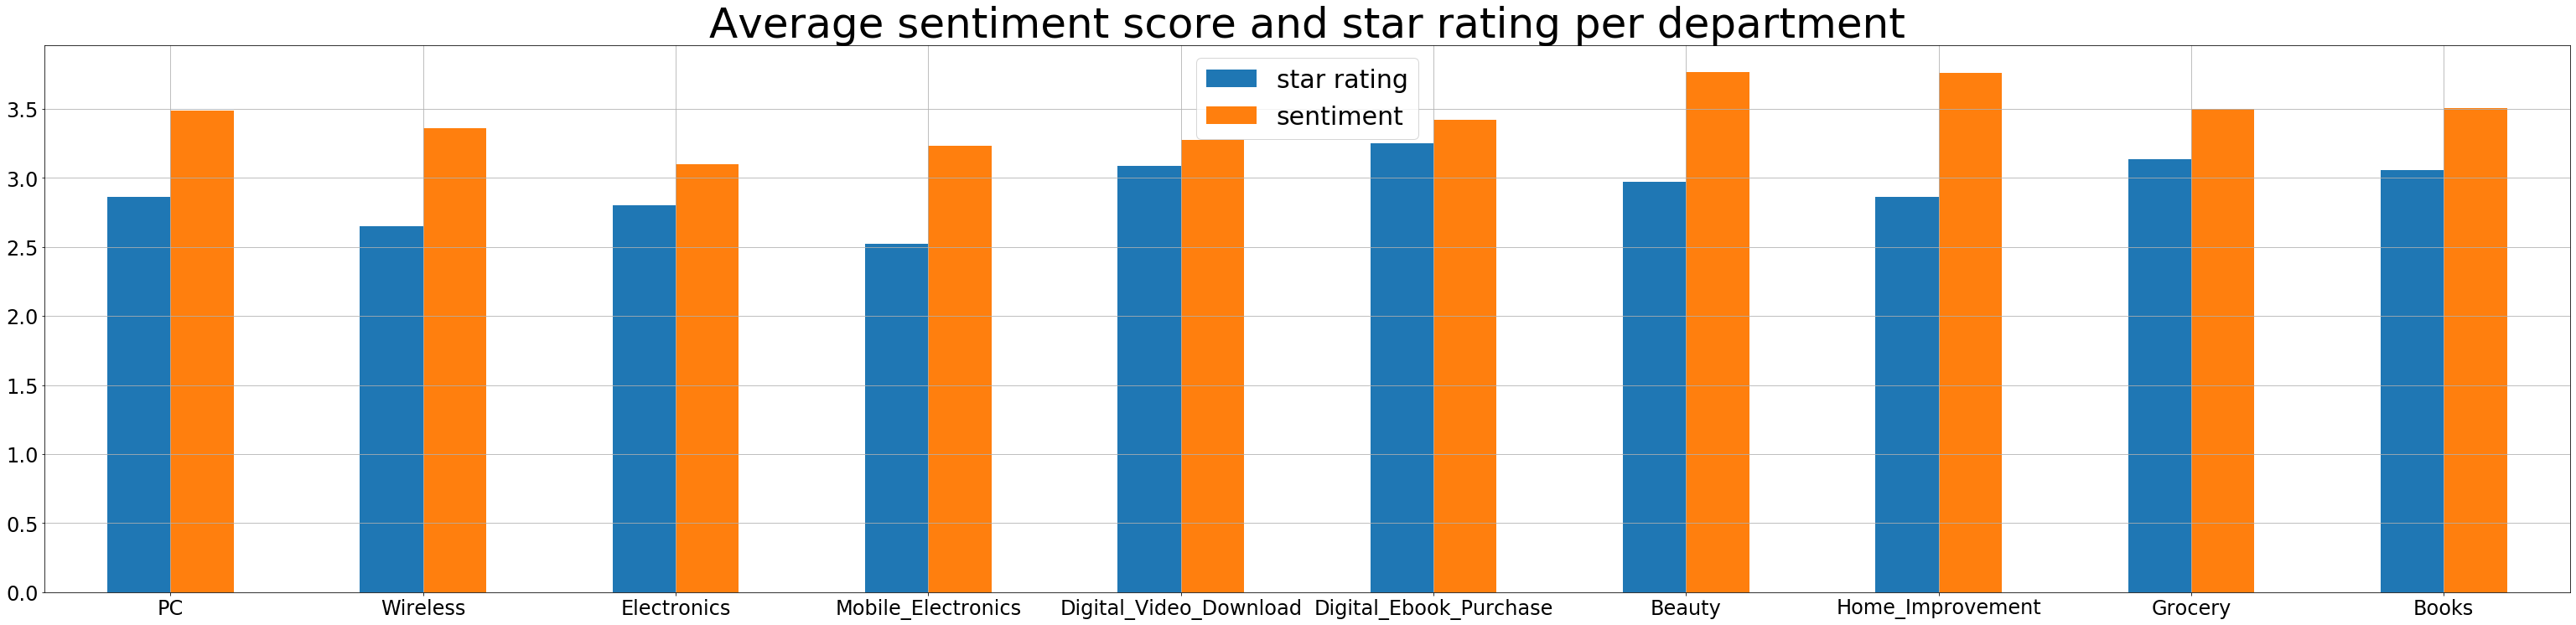

In [296]:
# Plot the chart
PC = [df20.select("star rating").filter(df20.product_category == 'PC').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'PC').collect()[0][0]]
Wireless = [df20.select("star rating").filter(df20.product_category == 'Wireless').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'Wireless').collect()[0][0]]
Electronics = [df20.select("star rating").filter(df20.product_category == 'Electronics').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'Electronics').collect()[0][0]]
Mobile_Electronics = [df20.select("star rating").filter(df20.product_category == 'Mobile_Electronics').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'Mobile_Electronics').collect()[0][0]]
Digital_Video_Download = [df20.select("star rating").filter(df20.product_category == 'Digital_Video_Download').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'Digital_Video_Download').collect()[0][0]]
Digital_Ebook_Purchase = [df20.select("star rating").filter(df20.product_category == 'Digital_Ebook_Purchase').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'Digital_Ebook_Purchase').collect()[0][0]]
Beauty = [df20.select("star rating").filter(df20.product_category == 'Beauty').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'Beauty').collect()[0][0]]
Home_Improvement = [df20.select("star rating").filter(df20.product_category == 'Home Improvement').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'Home Improvement').collect()[0][0]]
Grocery = [df20.select("star rating").filter(df20.product_category == 'Grocery').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'Grocery').collect()[0][0]]
Books = [df20.select("star rating").filter(df20.product_category == 'Books').collect()[0][0],
         df20.select("sentiment").filter(df20.product_category == 'Books').collect()[0][0]]
index = ['star rating', 'sentiment']
df21 = pd.DataFrame({'PC': PC, 'Wireless': Wireless, 'Electronics': Electronics, \
                     'Mobile_Electronics': Mobile_Electronics, 'Digital_Video_Download': Digital_Video_Download, \
                     'Digital_Ebook_Purchase': Digital_Ebook_Purchase, 'Beauty': Beauty, 'Home_Improvement': Home_Improvement, \
                     'Grocery': Grocery, 'Books': Books}, index=index)

plt.rcParams.update({'font.size': 24, 'axes.titlesize': 50})
df21.T.plot.bar(figsize=(54,12), grid=True, rot=0,  title="Average sentiment score and star rating per department")

Here we pick some popular departments to compare. A few conclusions drawn from the chart above.
1. Overall, the average sentiment score is higher than star rating. This indicates peaple tends to write slightly more positive reviews while giving a lower rating for the product, which means people have a higher standard on the product.
2. Digital products seem to have a smaller differences in the two scores compared with others. This makes sense as the delivery of these products is immediately and people get exactly what they expect so little difference between expectation and what's actually delivered.

### 3.2.2 time series analysis for average sentiment score and star rating

In [261]:
from pyspark.sql.functions import month, year, to_date
from pyspark.sql.functions import concat, col, lit

df22 = predictions3.withColumn('month', month(predictions3['review_date'])) \
       .withColumn('year', year(predictions3['review_date']))
df22 = df22.groupBy('year', 'month').agg(avg("star_rating").alias("average_star_rating"), \
      avg("prediction").alias("average_sentiment")).orderBy(["year", "month"], ascending=[1, 1])
df22 = df22.select(concat(col("year"), lit("-"), col("month")).alias("date"), "average_star_rating", "average_sentiment")
df22 = df22.withColumn("date", to_date(df22["date"], 'yyyy-MM').alias('date'))
df22.show()

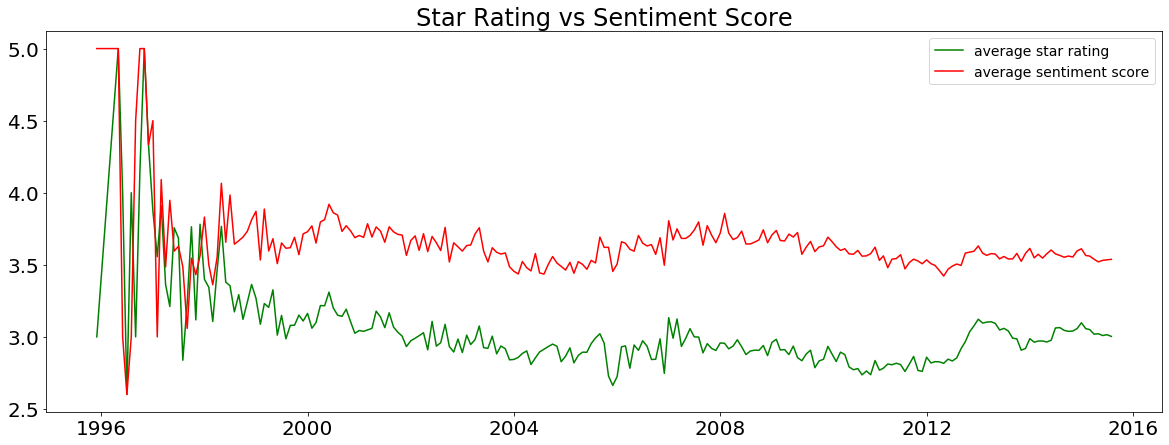

In [294]:
import matplotlib.pyplot as plt
# Plot the chart
df23 = df22.toPandas()
plt.figure(figsize=(20, 7))
# Plot a simple line chart
plt.plot(df23['date'], df23['average_star_rating'], 'g', label='average star rating')
plt.plot(df23['date'], df23['average_sentiment'], 'r', label='average sentiment score')
plt.title('Star Rating vs Sentiment Score')
plt.legend()
plt.rcParams.update({'font.size': 20, 'axes.titlesize':24})
plt.show()

A few conclusions drawn from the chart above.
1. Overall, the average sentiment score is higher than star rating. This aligns with the analysis from previous chart.
2. In the late 1990s, there is large variance in both star rating and sentiment score, reflecting customers less confidence in the product Amazon offered or maybe the company itself, possibly due to Dot-com bubble.
3. There is seasonality in both star rating and sentiment score.

### 3.2.3 density chart for star rating and sentiment score

Text(0.5, 1.0, 'Star Rating vs Sentiment Score Distribution')

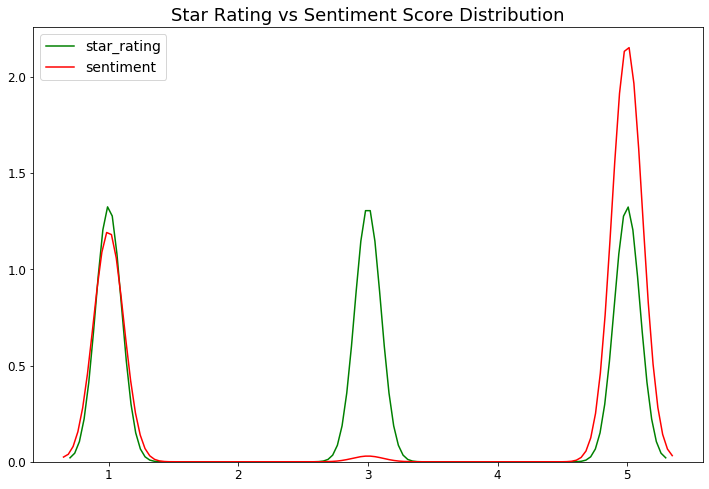

In [292]:
import seaborn as sns
df24 = predictions3.select('star_rating','prediction').withColumnRenamed('prediction','sentiment').toPandas()
plt.figure(figsize=(12, 8))
sns.kdeplot(df24['star_rating'], color='g')
sns.kdeplot(df24['sentiment'], color='r')
plt.rcParams.update({'font.size': 12, 'axes.titlesize':18})
plt.title('Star Rating vs Sentiment Score Distribution')

A few conclusions drawn from the chart above.
1. As expected, the class distribution for star rating is well balanced, as we resampled the data.
2. For each score 1 3 5, the data distribution conforms with normal distribution, regardless of star rating or sentiment scores.
3. The sentiment score predicts very well when the rating is low, but underrepresents when the rating is medium and overrepresents when the rating is high.

## 4. ALS recommendation system

### 4.1 Pull out data needed

#### We only select those customers posting more than 20 reviews

The total number of rows is 3.4M

In [38]:
above20 = df.groupby('customer_id').count().filter(("count>20")).withColumnRenamed("customer_id", "customer_id1")

In [39]:
dfALS = df.select(['customer_id', 'product_id', 'star_rating','product_title'])

In [40]:
dfALS = dfALS.dropna()

In [41]:
dfALS=dfALS.join(above20, dfALS['customer_id'] == above20['customer_id1'], 'outer').dropna()

In [42]:
dfALS=dfALS.drop('count','customer_id1')

In [38]:
dfALS.describe().show()

+-------+--------------------+-----------------+--------------------+------------------+
|summary|         customer_id|      star_rating|       product_title|    product_id_int|
+-------+--------------------+-----------------+--------------------+------------------+
|  count|            33986373|         33986373|            33986373|          33986373|
|   mean| 3.104720128764193E7|4.278052059276817|            Infinity|1108879.2584926023|
| stddev|1.5166855571340729E7|1.148374227152167|                 NaN|  1779715.43878492|
|    min|               10141|                1| Ghosts Of The Past |                 1|
|    max|            53096570|                5|🌴 Vacation On Th...|           7425309|
+-------+--------------------+-----------------+--------------------+------------------+



#### Change ID from string type to integer

In [43]:
dfALS = dfALS.withColumn("customer_id", col("customer_id").cast("int"))

In [17]:
dfALS.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- product_title: string (nullable = true)



#### Change product ID to integer by assigning a integer to each distinct product_id

In [44]:
product = dfALS.groupby('product_id').count()

In [45]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import desc
windowSpec  = Window.orderBy(desc('count'))

In [46]:
product=product.withColumn("rank",row_number().over(windowSpec)).withColumnRenamed("product_id", "product_id1")

In [47]:
dfALS=dfALS.join(product, dfALS['product_id'] == product['product_id1'], 'outer').dropna()

In [48]:
dfALS=dfALS.drop('count','product_id1','product_id')

In [49]:
dfALS=dfALS.withColumnRenamed("rank", "product_id_int")

In [24]:
dfALS.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- star_rating: integer (nullable = true)
 |-- product_title: string (nullable = true)
 |-- product_id_int: integer (nullable = true)



In [50]:
training, test = dfALS.randomSplit([0.8,0.2],seed=20)

### 4.2 Matrix Factorization with ALS

In [51]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

In [57]:
als = ALS(maxIter=10, regParam=0.1, userCol="customer_id", itemCol="product_id_int", ratingCol="star_rating",
          coldStartStrategy="drop", nonnegative = True)

In [27]:
model = als.fit(training)

#### Save the model

In [28]:
model.save('ALS_model_data20')

#### Load the model

In [52]:
from pyspark.ml.recommendation import ALSModel
model = ALSModel.load("ALS_model_data20")

In [53]:
predictions = model.transform(test)

In [45]:
#item factors 
model.itemFactors.show(10, truncate = False)

+---+-------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                           |
+---+-------------------------------------------------------------------------------------------------------------------+
|6  |[0.70134395, 0.74286336, 0.76634455, 0.691478, 0.70697147, 0.7035044, 0.75799227, 0.7346017, 0.70211476, 0.8180656]|
|16 |[0.6198038, 0.67492074, 0.70567393, 0.8307945, 0.6282556, 0.5326424, 0.75119275, 0.5261406, 0.9314737, 0.6426817]  |
|26 |[0.869274, 0.35159343, 0.27245533, 0.05261048, 0.85478157, 0.72648233, 1.260029, 0.0, 0.7621283, 1.0424353]        |
|36 |[0.73772, 0.75519866, 0.69749236, 0.8192574, 0.8175333, 0.54180235, 0.7800141, 0.7040451, 0.71730167, 0.81239593]  |
|46 |[0.8491549, 0.6341703, 0.8582439, 0.84069383, 0.7366504, 0.5399502, 0.87908167, 0.5407958, 0.6725431, 0.56700623]  |
|56 |[0.6705508, 0.73577

In [54]:
predictions.show(10, truncate = False)

+-----------+-----------+-------------------------------------------------------------------------+--------------+----------+
|customer_id|star_rating|product_title                                                            |product_id_int|prediction|
+-----------+-----------+-------------------------------------------------------------------------+--------------+----------+
|11369064   |5          |WeatherBug - Free Local Weather Forecast, Radar Map & Severe Storm Alerts|148           |3.7152686 |
|51176540   |5          |WeatherBug - Free Local Weather Forecast, Radar Map & Severe Storm Alerts|148           |4.0192466 |
|20139109   |4          |WeatherBug - Free Local Weather Forecast, Radar Map & Severe Storm Alerts|148           |5.0342197 |
|24922169   |3          |WeatherBug - Free Local Weather Forecast, Radar Map & Severe Storm Alerts|148           |3.8141298 |
|51046154   |5          |WeatherBug - Free Local Weather Forecast, Radar Map & Severe Storm Alerts|148           |4.64

#### Prediction Performance with test dataset

In [55]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='star_rating')
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.364581601743907


The root mean square error is 1.36, which is not bad.

### 4.3 Predictions

#### Generate top 10 product recommendations for a specified set of customers

In [58]:
users = dfALS.select(als.getUserCol()).distinct().limit(3)
userSubsetRecs = model.recommendForUserSubset(users, 10)

userSubsetRecs.show(10, truncate=False)

+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_id|recommendations                                                                                                                                                                                                          |
+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|44983593   |[[3420239, 8.177787], [2025301, 7.003613], [2237518, 6.6813326], [2297997, 6.6741185], [2321541, 6.6617546], [1324487, 6.629077], [5983039, 6.5676193], [4694111, 6.5676193], [5578929, 6.5676193], [5222416, 6.5676193]]|
|53016588   |[[1492998, 7.0925403], [3257187, 6.721196], [6469425, 6.708

#### We can look into the customer ID 44983593:

What product did he/she purchase?

In [96]:
itemname_customer=df.filter(('customer_id==44983593 and star_rating>4')).select('product_title','product_category').distinct().toPandas()
itemname_customer

,product_title,product_category
0,"Day Runner Nature Weekly Planner Refill 2015, ...",Office Products
1,WORLD OF WARCRAFT HORDE PVP - WOW - Vinyl Car ...,Automotive
2,ProDen PlaqueOff Dental Powder,Pet Products
3,Prevue Pet Products 62605 Calypso Creations Sh...,Pet Products
4,"Prestige Medical 607 Fluoride Coated Scissor, ...",Health & Personal Care
5,MUJI Aluminum Body Fountain Pen - Fine Nib - w...,Office Products
6,Constructive Anatomy (Dover Anatomy for Artists),Books
7,"RCA ANT111Z Durable FM Antenna, Rabbit Ears",Electronics
8,Logitech LX7 Cordless Optical Mouse,PC
9,Erase Markers,Office Products


What kind of product did he/she purchase?

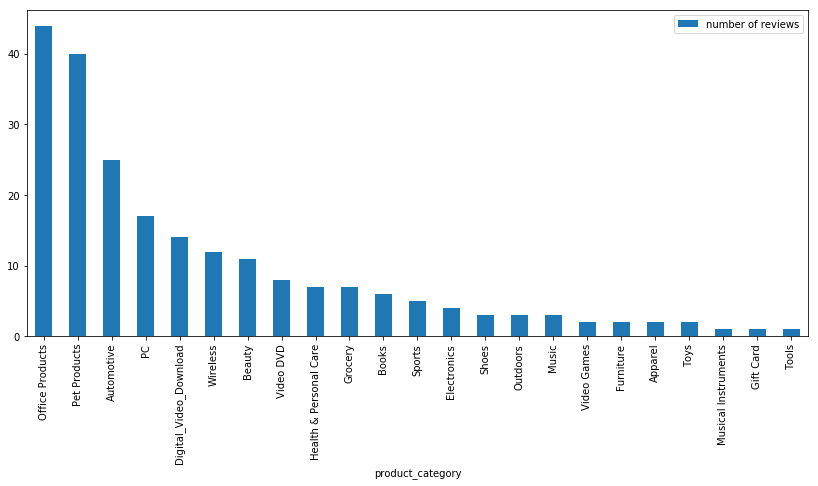

In [88]:
customer_count = df.filter(('customer_id==44983593')).groupby('product_category').count().orderBy('count', ascending=False)
customer_count = customer_count.toPandas()
customer_count.rename(columns = {'count':'number of reviews'}, inplace = True)
customer_count.plot.bar(x='product_category',figsize=(14, 6))

How did he/she rate the product? (by category)

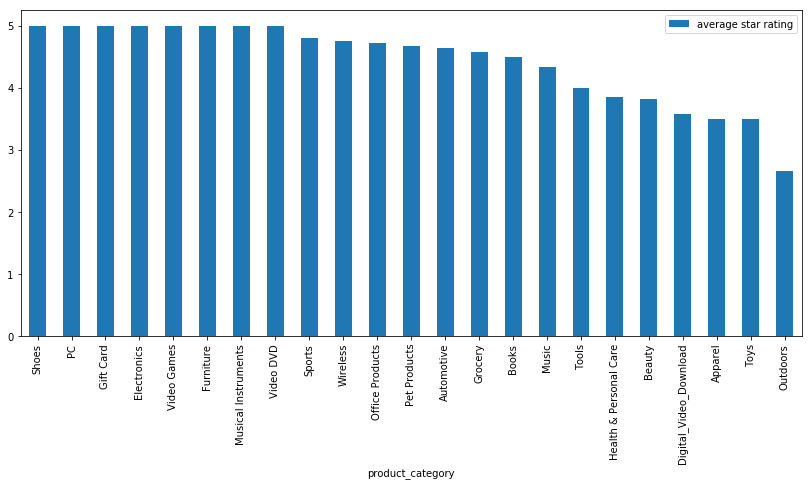

In [87]:
customer_rating = df.filter(('customer_id==44983593')).groupby('product_category').avg('star_rating').orderBy('avg(star_rating)', ascending=False)
customer_rating = customer_rating.toPandas()
customer_rating.rename(columns = {'avg(star_rating)':'average star rating'}, inplace = True)
customer_rating.plot.bar(x='product_category',figsize=(14, 6))

In [81]:
customerproduct = product.filter(('rank==3420239 or rank==2025301 or rank==2237518 or rank==2297997 or rank==2321541 or rank==1324487 or rank==5983039 or rank==4694111 or rank==5578929 or rank==5222416'))

In [69]:
customerproduct.show()

+-----------+-----+-------+
|product_id1|count|   rank|
+-----------+-----+-------+
| B00G79IDE8|    4|1324487|
| 0563555777|    2|2025301|
| B001HLIOG8|    2|2237518|
| B004BTM0FO|    2|2297997|
| B0000302UC|    2|2321541|
| B00DH7KPPI|    1|3420239|
| B00K3OLVBA|    1|4694111|
| B00ATTQZEC|    1|5222416|
| B003BLOPNS|    1|5578929|
| B0018BVRG6|    1|5983039|
+-----------+-----+-------+



In [84]:
customerproduct = customerproduct.join(df, customerproduct['product_id1'] == df['product_id'], 'outer').drop('customer_id', 'star_rating','helpful_votes','total_votes','vine','verified_purchase','review_headline','review_body','review_date','year','month','year_month','count').dropna().distinct()

What is recommended to ID 44983593?

In [92]:
itemname=customerproduct.select('product_title','product_category').toPandas()
itemname

,product_title,product_category
0,Pure Spirulina Powder (5 lbs) Protein Superfoo...,Health & Personal Care
1,A Picture Book of Thomas Jefferson (Picture Bo...,Books
2,Reiko Magnetic Closure Flip Case for Samsung G...,Wireless
3,"Quilted Purse, Handbag, Wallet - Black, Pink, ...",Shoes
4,Sparkle Wide Headband,Sports
5,Genuine Apple iMac Power Cord - 922-7139 922-9...,PC
6,Blondo Women's Marcia Knee-High Boot,Shoes
7,Jensen Shower Radio &#45; JWM125,Electronics
8,Pert Plus 2 in 1 Shampoo + Conditioner Dandruf...,Beauty
9,Snowflake Thank You Cards (24 Foldover Cards a...,Office Products


We found that the system recommends similar items that were puchased by the customer. (i.e. samsong phone case, shampoo, shower radio, etc.)

What categoy is recommended?

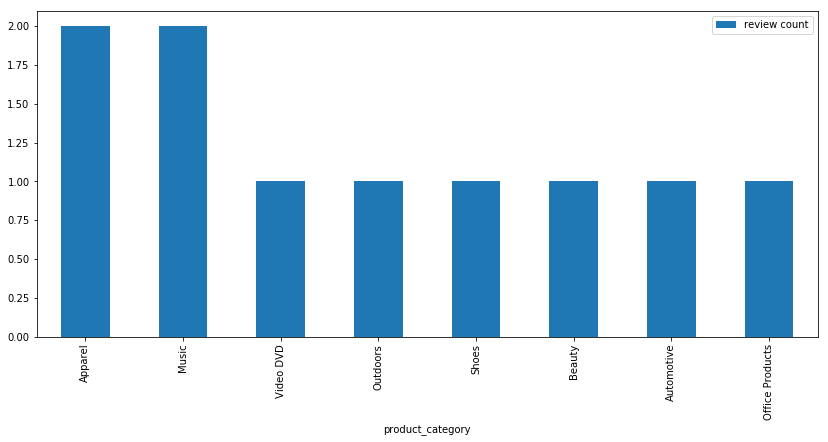

In [85]:
pdf=customerproduct.groupby('product_category').count().orderBy("count", ascending=False)
pdf=pdf.toPandas()
pdf.rename(columns = {'count':'review count'}, inplace = True)
pdf.plot.bar(x='product_category',figsize=(14, 6))

The system recommend 10 objects that fall into 8 product categories shown as above. It recommends not only  products in categories that were rated higher by the customer (i.e. shoes and video DVD), but also those with lower ratings (i.e. apparel, outdoors). However, most of recommendations are from categories frequently bought by the customer, and the recommendation system still follows the customer's past purchase pattern. Therefore, we think the recommendation system is effective enough.

#### Generate top 10 user recommendations for a specified set of products

In [35]:
product = dfALS.select(als.getItemCol()).distinct().limit(3)
productSubSetRecs = model.recommendForItemSubset(product, 10)

productSubSetRecs.show(10, truncate=False)

+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_id_int|recommendations                                                                                                                                                                                                                     |
+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2194008       |[[17013586, 2.3507779], [27323062, 2.2896912], [13523339, 2.278379], [15200426, 2.266658], [10533597, 2.2352118], [12117892, 2.2341156], [14541209, 2.2227483], [15450180, 2.21398], [20203478, 2.2119827], [22737322, 2.2098374]]  |
|2202666       |

In [36]:
dfALS.select('product_title','product_id_int').distinct().filter(('product_id_int==2194008 OR product_id_int==2202666 OR product_id_int==4308616')).show()

+--------------------+--------------+
|       product_title|product_id_int|
+--------------------+--------------+
|Wartech Tactical ...|       2202666|
|Sports Shield Foo...|       4308616|
|     It's Impossible|       2194008|
+--------------------+--------------+

